In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
ruta = 'data/df_limpio.csv'
df = pd.read_csv(ruta)
df.head()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Area,Status
0,0.072991,-0.554487,0.097515,0.276642,0.432861,1.0,0.0,0.0,0.0,0.0,2.0,1.0
1,-0.134412,-0.038732,-0.152244,0.276642,0.432861,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.393747,-0.554487,-0.856110,0.276642,0.432861,1.0,1.0,0.0,0.0,1.0,2.0,1.0
3,-0.462062,0.251980,-0.243065,0.276642,0.432861,1.0,1.0,0.0,1.0,0.0,2.0,1.0
4,0.097728,-0.554487,-0.004659,0.276642,0.432861,1.0,0.0,0.0,0.0,0.0,2.0,1.0


### Distribución de datos faltantes

Text(0.5, 1.0, 'Valores faltantes')

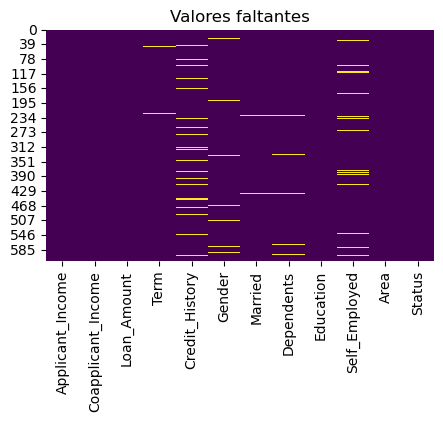

In [3]:
plt.figure(figsize=(5,3))
sns.heatmap(df.isnull(), cbar = False, cmap='viridis')
plt.title('Valores faltantes')

### Creación del imputador MICE

In [ ]:
imputer = IterativeImputer(
    max_iter=1,       
    random_state=42,       
    initial_strategy='mean')

df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

imputer.get_params()

/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


{'add_indicator': False,
 'estimator': None,
 'fill_value': None,
 'imputation_order': 'ascending',
 'initial_strategy': 'mean',
 'keep_empty_features': False,
 'max_iter': 1,
 'max_value': inf,
 'min_value': -inf,
 'missing_values': nan,
 'n_nearest_features': None,
 'random_state': 42,
 'sample_posterior': False,
 'skip_complete': False,
 'tol': 0.001,
 'verbose': 0}

In [5]:
print("\nDatos después de la imputación:")
print(df_imputed.isnull().sum())


Datos después de la imputación:
Applicant_Income      0
Coapplicant_Income    0
Loan_Amount           0
Term                  0
Credit_History        0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
Area                  0
Status                0
dtype: int64


### Comparación de los valores imputados

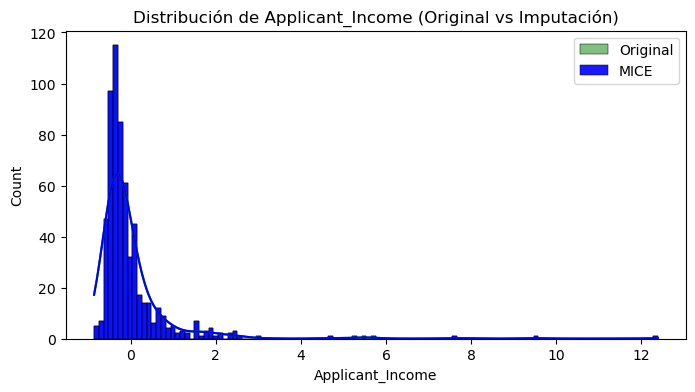

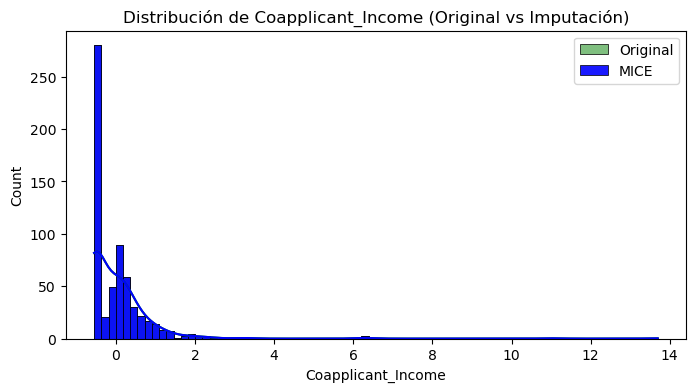

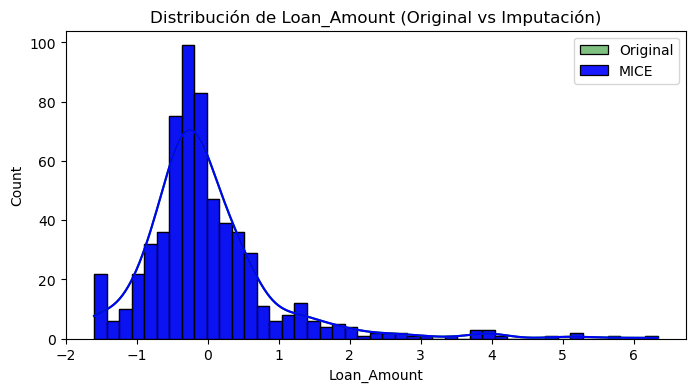

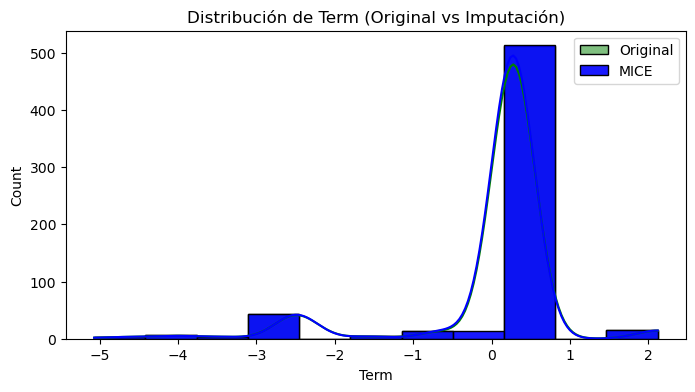

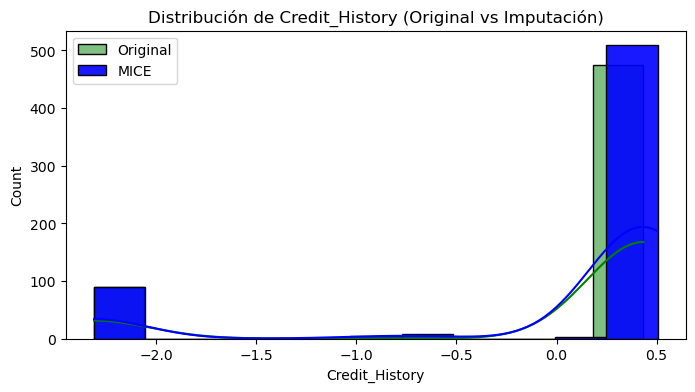

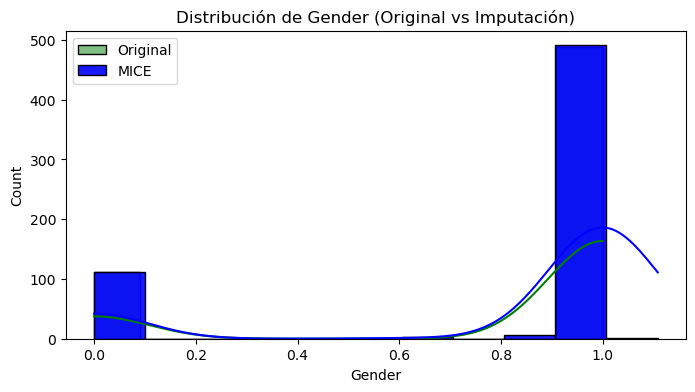

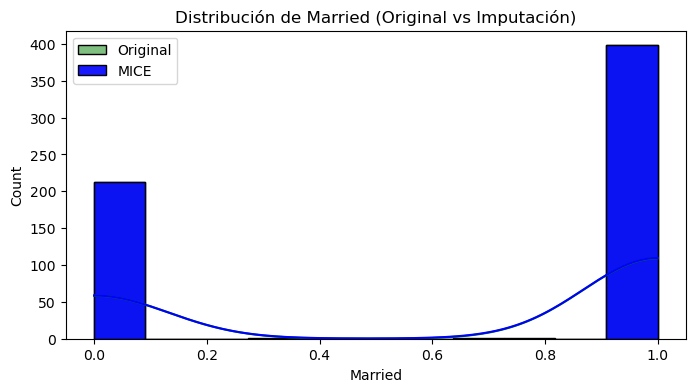

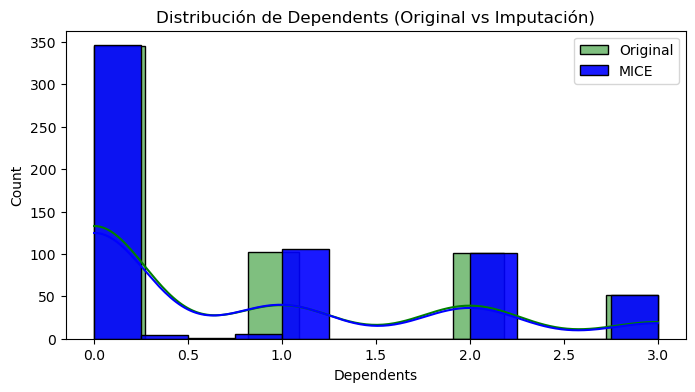

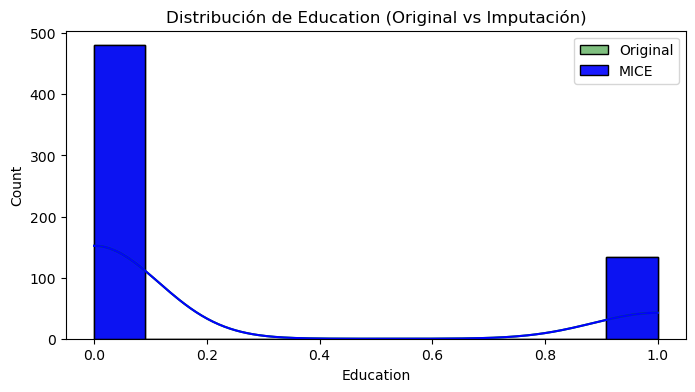

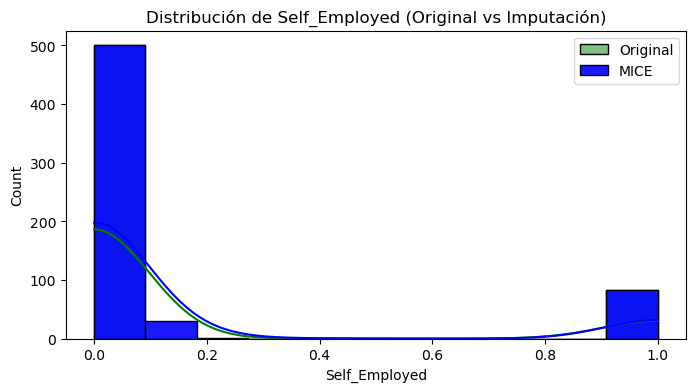

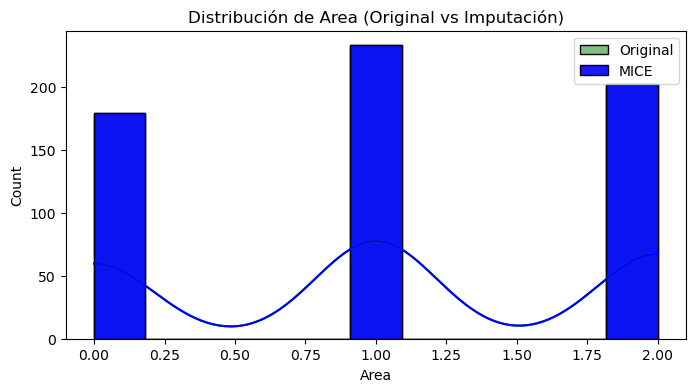

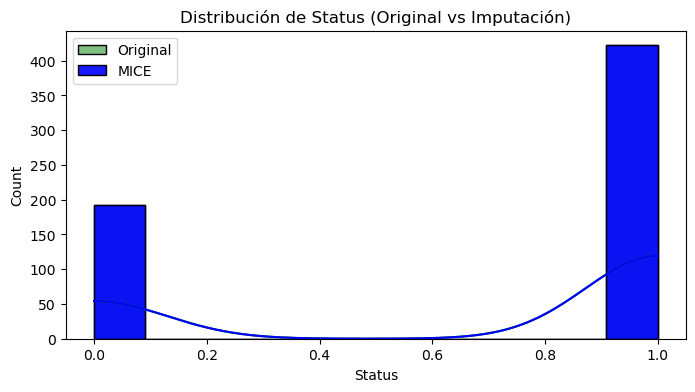

In [9]:
for col in df.columns:
    plt.figure(figsize=(8,4))
    # Originales
    sns.histplot(df[col], color = 'green', label = 'Original', kde = True, alpha = 0.5)
    # Imputados con MICE
    sns.histplot(df_imputed[col], color = 'blue', label = 'MICE', kde = True, alpha = 0.9)
    plt.title(f'Distribución de {col} (Original vs Imputación)')
    plt.legend()

### Efecto del número de iteraciónes en el algoritmo MICE

/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


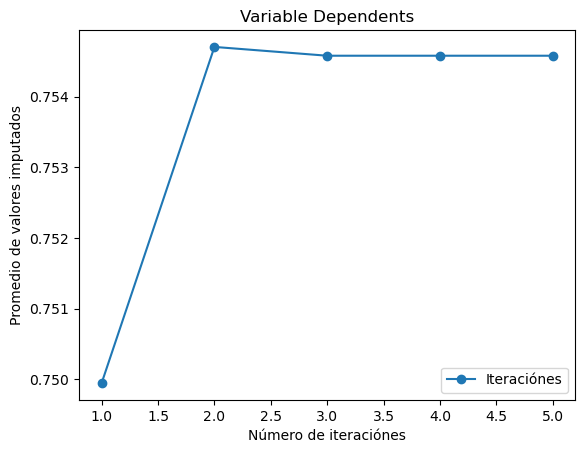

In [23]:
idx_faltantes = df[df['Dependents'].isnull()].index

its = [1, 2, 3, 4, 5]
promedio_imputaciones = []

for it in its:
    imputador = IterativeImputer(max_iter=it, random_state=42)
    imputaciones = imputador.fit_transform(df)

    promedio = imputaciones[idx_faltantes, 7].mean()
    promedio_imputaciones.append(promedio)

plt.plot(its, promedio_imputaciones, marker = 'o', label = 'Iteraciónes')
plt.title('Variable Dependents')
plt.xlabel('Número de iteraciónes')
plt.ylabel('Promedio de valores imputados')
plt.legend()
plt.show()